In [26]:
# !python /Applications/CPLEX_Studio2211/python/setup.py install

In [27]:
from docplex.mp.model import Model

# -----------------------
# Data and Parameters
# -----------------------
num_nurses = 100
nurses = range(num_nurses)

# Skills: assume four skills: A, B, C, D
skills = ["A", "B", "C", "D"]

# Days of planning horizon: we use 7 days (Sunday to Saturday) for illustration
days = list(range(7))
day_names = {
    0: "Sunday",
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday",
}

# Shifts: Morning, Afternoon, Night (each 8 hours)
shifts = ["Morning", "Afternoon", "Night"]

# Define working hour limits (in hours)
min_hours = 40  # minimum hours per nurse per week
ideal_max_hours = (
    45  # ideal maximum hours per nurse per week (not used in hard constraint)
)
max_hours = 50  # absolute maximum if needed

# Weights for the objective (example values)
w1 = 1  # overtime penalty weight
w2 = 1  # unfair distribution penalty weight
w3 = 1  # nurse satisfaction benefit weight
w4 = 1  # shift coverage benefit weight

# -----------------------
# Procedure – Skill Coefficient Matrix
# -----------------------
procedure_skill_coef = {
    "p1": {"A": 1, "B": 1, "C": 1, "D": 0},
    "p2": {"A": 2, "B": 0, "C": 1, "D": 0},
    "p3": {"A": 1, "B": 1, "C": 0, "D": 1},
    "p4": {"A": 2, "B": 0, "C": 0, "D": 1},
    "p5": {"A": 0, "B": 2, "C": 1, "D": 1},
    "p6": {"A": 1, "B": 0, "C": 0, "D": 2},
    "p7": {"A": 2, "B": 0, "C": 1, "D": 1},
    "p8": {"A": 2, "B": 0, "C": 0, "D": 1},
    "p9": {"A": 0, "B": 1, "C": 0, "D": 2},
    "p10": {"A": 0, "B": 1, "C": 2, "D": 0},
}

# -----------------------
# Coverage Requirements per Day, Shift, and Procedure
# -----------------------
coverage_requirements = {
    "Sunday": {
        "p1": {"Morning": 4, "Afternoon": 3, "Night": 2},
        "p2": {"Morning": 5, "Afternoon": 2, "Night": 1},
        "p3": {"Morning": 3, "Afternoon": 3, "Night": 0},
        "p4": {"Morning": 3, "Afternoon": 3, "Night": 0},
        "p5": {"Morning": 4, "Afternoon": 4, "Night": 0},
    },
    "Monday": {
        "p1": {"Morning": 5, "Afternoon": 4, "Night": 3},
        "p2": {"Morning": 5, "Afternoon": 4, "Night": 2},
        "p3": {"Morning": 5, "Afternoon": 4, "Night": 1},
        "p4": {"Morning": 5, "Afternoon": 4, "Night": 1},
        "p5": {"Morning": 6, "Afternoon": 6, "Night": 1},
    },
    "Tuesday": {
        "p1": {"Morning": 5, "Afternoon": 4, "Night": 3},
        "p2": {"Morning": 5, "Afternoon": 4, "Night": 2},
        "p3": {"Morning": 5, "Afternoon": 4, "Night": 1},
        "p4": {"Morning": 5, "Afternoon": 4, "Night": 1},
        "p5": {"Morning": 6, "Afternoon": 6, "Night": 1},
    },
    "Wednesday": {
        "p1": {"Morning": 5, "Afternoon": 4, "Night": 3},
        "p2": {"Morning": 5, "Afternoon": 4, "Night": 2},
        "p3": {"Morning": 5, "Afternoon": 4, "Night": 1},
        "p4": {"Morning": 5, "Afternoon": 4, "Night": 1},
        "p5": {"Morning": 6, "Afternoon": 6, "Night": 1},
    },
    "Thursday": {
        "p1": {"Morning": 5, "Afternoon": 4, "Night": 3},
        "p2": {"Morning": 5, "Afternoon": 4, "Night": 2},
        "p3": {"Morning": 5, "Afternoon": 4, "Night": 1},
        "p4": {"Morning": 5, "Afternoon": 4, "Night": 1},
        "p5": {"Morning": 6, "Afternoon": 6, "Night": 1},
    },
    "Friday": {
        "p1": {"Morning": 5, "Afternoon": 4, "Night": 3},
        "p2": {"Morning": 5, "Afternoon": 4, "Night": 2},
        "p3": {"Morning": 5, "Afternoon": 4, "Night": 1},
        "p4": {"Morning": 5, "Afternoon": 4, "Night": 1},
        "p5": {"Morning": 6, "Afternoon": 6, "Night": 1},
    },
    "Saturday": {
        "p1": {"Morning": 4, "Afternoon": 3, "Night": 2},
        "p2": {"Morning": 5, "Afternoon": 2, "Night": 1},
        "p3": {"Morning": 3, "Afternoon": 3, "Night": 0},
        "p4": {"Morning": 3, "Afternoon": 3, "Night": 0},
        "p5": {"Morning": 4, "Afternoon": 4, "Night": 0},
    },
}

# # For Tuesday-Friday, use the same as Monday; Saturday uses Sunday.
# for d in ["Tuesday", "Wednesday", "Thursday", "Friday"]:
#     coverage_requirements[d] = coverage_requirements["Monday"]
# coverage_requirements["Saturday"] = coverage_requirements["Sunday"]

# -----------------------
# Model Definition
# -----------------------
mdl = Model("NurseScheduling")

# Decision Variables:
# x[i, j, k, l] = 1 if nurse i is assigned to skill j on day k during shift l; 0 otherwise.
x = mdl.binary_var_dict(
    [(i, j, k, l) for i in nurses for j in skills for k in days for l in shifts],
    name="x",
)

# Auxiliary variables to capture overtime for each nurse.
# Overtime is defined as the positive part of (total_hours - min_hours)
overtime = {i: mdl.continuous_var(lb=0, name=f"overtime_{i}") for i in nurses}

# -----------------------
# Constraints
# -----------------------

# 1. Each nurse works at most one shift per day.
for i in nurses:
    for k in days:
        mdl.add_constraint(
            mdl.sum(x[i, j, k, l] for j in skills for l in shifts) <= 1,
            ctname=f"one_shift_per_day_nurse_{i}_day_{k}",
        )

# 2. Weekly working hours constraints.
# Each shift is 8 hours.
for i in nurses:
    total_hours = mdl.sum(
        8 * x[i, j, k, l] for j in skills for k in days for l in shifts
    )
    mdl.add_constraint(total_hours >= min_hours, ctname=f"min_hours_nurse_{i}")
    mdl.add_constraint(total_hours <= max_hours, ctname=f"max_hours_nurse_{i}")
    # Overtime definition: overtime[i] >= total_hours - min_hours.
    mdl.add_constraint(
        overtime[i] >= total_hours - min_hours, ctname=f"overtime_constraint_{i}"
    )

# 3. No more than 5 consecutive working days.
for i in nurses:
    for start in range(len(days) - 5):
        mdl.add_constraint(
            mdl.sum(
                x[i, j, k, l]
                for j in skills
                for l in shifts
                for k in range(start, start + 6)
            )
            <= 5,
            ctname=f"max_5_consec_days_nurse_{i}_window_start_{start}",
        )

# 4. Rest time / Night shift constraints:
# If a nurse works a night shift on day k, then they cannot work any shift on day k+1.
for i in nurses:
    for k in range(len(days) - 1):
        mdl.add_constraint(
            mdl.sum(x[i, j, k + 1, l] for j in skills for l in shifts)
            <= 1 - mdl.sum(x[i, j, k, "Night"] for j in skills),
            ctname=f"no_shift_after_night_nurse_{i}_day_{k}",
        )

# 5. Vacation Leave constraints:
# For demonstration, assume no vacations (modify as needed).
vacation_days = {i: set() for i in nurses}
for i in nurses:
    for k in vacation_days[i]:
        mdl.add_constraint(
            mdl.sum(x[i, j, k, l] for j in skills for l in shifts) == 0,
            ctname=f"vacation_nurse_{i}_day_{k}",
        )

# 6. Coverage Constraints:
for k in days:
    day_str = day_names[k]
    for proc, shift_req in coverage_requirements[day_str].items():
        for l in shifts:
            mdl.add_constraint(
                mdl.sum(
                    procedure_skill_coef[proc][j] * x[i, j, k, l]
                    for i in nurses
                    for j in skills
                )
                >= shift_req[l],
                ctname=f"coverage_{proc}_{day_str}_{l}",
            )

# -----------------------
# Objective Function
# -----------------------
# For illustration:
# - Overtime penalty: Sum of overtime for all nurses.
# - Fairness penalty: Difference between maximum and minimum total hours among nurses.
# - Nurse satisfaction and shift coverage terms are placeholders.

# Fairness: Define auxiliary variables for maximum and minimum total hours.
max_hours_var = mdl.continuous_var(name="max_hours_var")
min_hours_var = mdl.continuous_var(name="min_hours_var")
for i in nurses:
    total_hours_i = mdl.sum(
        8 * x[i, j, k, l] for j in skills for k in days for l in shifts
    )
    mdl.add_constraint(
        total_hours_i <= max_hours_var, ctname=f"max_hours_def_nurse_{i}"
    )
    mdl.add_constraint(
        total_hours_i >= min_hours_var, ctname=f"min_hours_def_nurse_{i}"
    )
fairness_penalty = max_hours_var - min_hours_var

# Nurse satisfaction: placeholder (assumed 0 for this example).
nurse_satisfaction = 0

# Shift coverage: already enforced as hard constraints (placeholder if needed).
shift_coverage_penalty = 0

# Total objective function
objective = (
    w1 * mdl.sum(overtime[i] for i in nurses)
    + w2 * fairness_penalty
    - w3 * nurse_satisfaction
    + w4 * shift_coverage_penalty
)
mdl.minimize(objective)

# -----------------------
# Solve the Model
# -----------------------
solution = mdl.solve(log_output=True)
if solution:
    mdl.print_solution()
else:
    print("No solution found")


Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 611 rows and 342 columns.
MIP Presolve modified 1500 coefficients.
Reduced MIP has 1494 rows, 8160 columns, and 88427 nonzeros.
Reduced MIP has 8058 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (62.17 ticks)
Found incumbent of value 40.000000 after 0.11 sec. (164.31 ticks)
Probing time = 0.00 sec. (4.53 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 0 rows and 14 columns.
Reduced MIP has 1494 rows, 8146 columns, and 88298 nonzeros.
Reduced MIP has 8044 binaries, 102 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (59.35 ticks)
Probing time = 0.00 sec. (4.49 ticks)
Clique table members: 700.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0

                 Sunday         Monday        Tuesday      Wednesday  \
Nurse 0                  Afternoon (B)                   Morning (A)   
Nurse 1   Afternoon (C)                                  Morning (C)   
Nurse 2   Afternoon (C)      Night (A)                 Afternoon (D)   
Nurse 3                                   Morning (B)    Morning (B)   
Nurse 4                  Afternoon (D)                 Afternoon (B)   
...                 ...            ...            ...            ...   
Nurse 95                   Morning (A)  Afternoon (C)      Night (C)   
Nurse 96  Afternoon (B)  Afternoon (D)                 Afternoon (C)   
Nurse 97                   Morning (C)    Morning (D)      Night (C)   
Nurse 98    Morning (D)      Night (A)                     Night (C)   
Nurse 99  Afternoon (A)                   Morning (A)  Afternoon (D)   

               Thursday         Friday       Saturday  Total Hours  
Nurse 0   Afternoon (C)    Morning (C)  Afternoon (C)           40

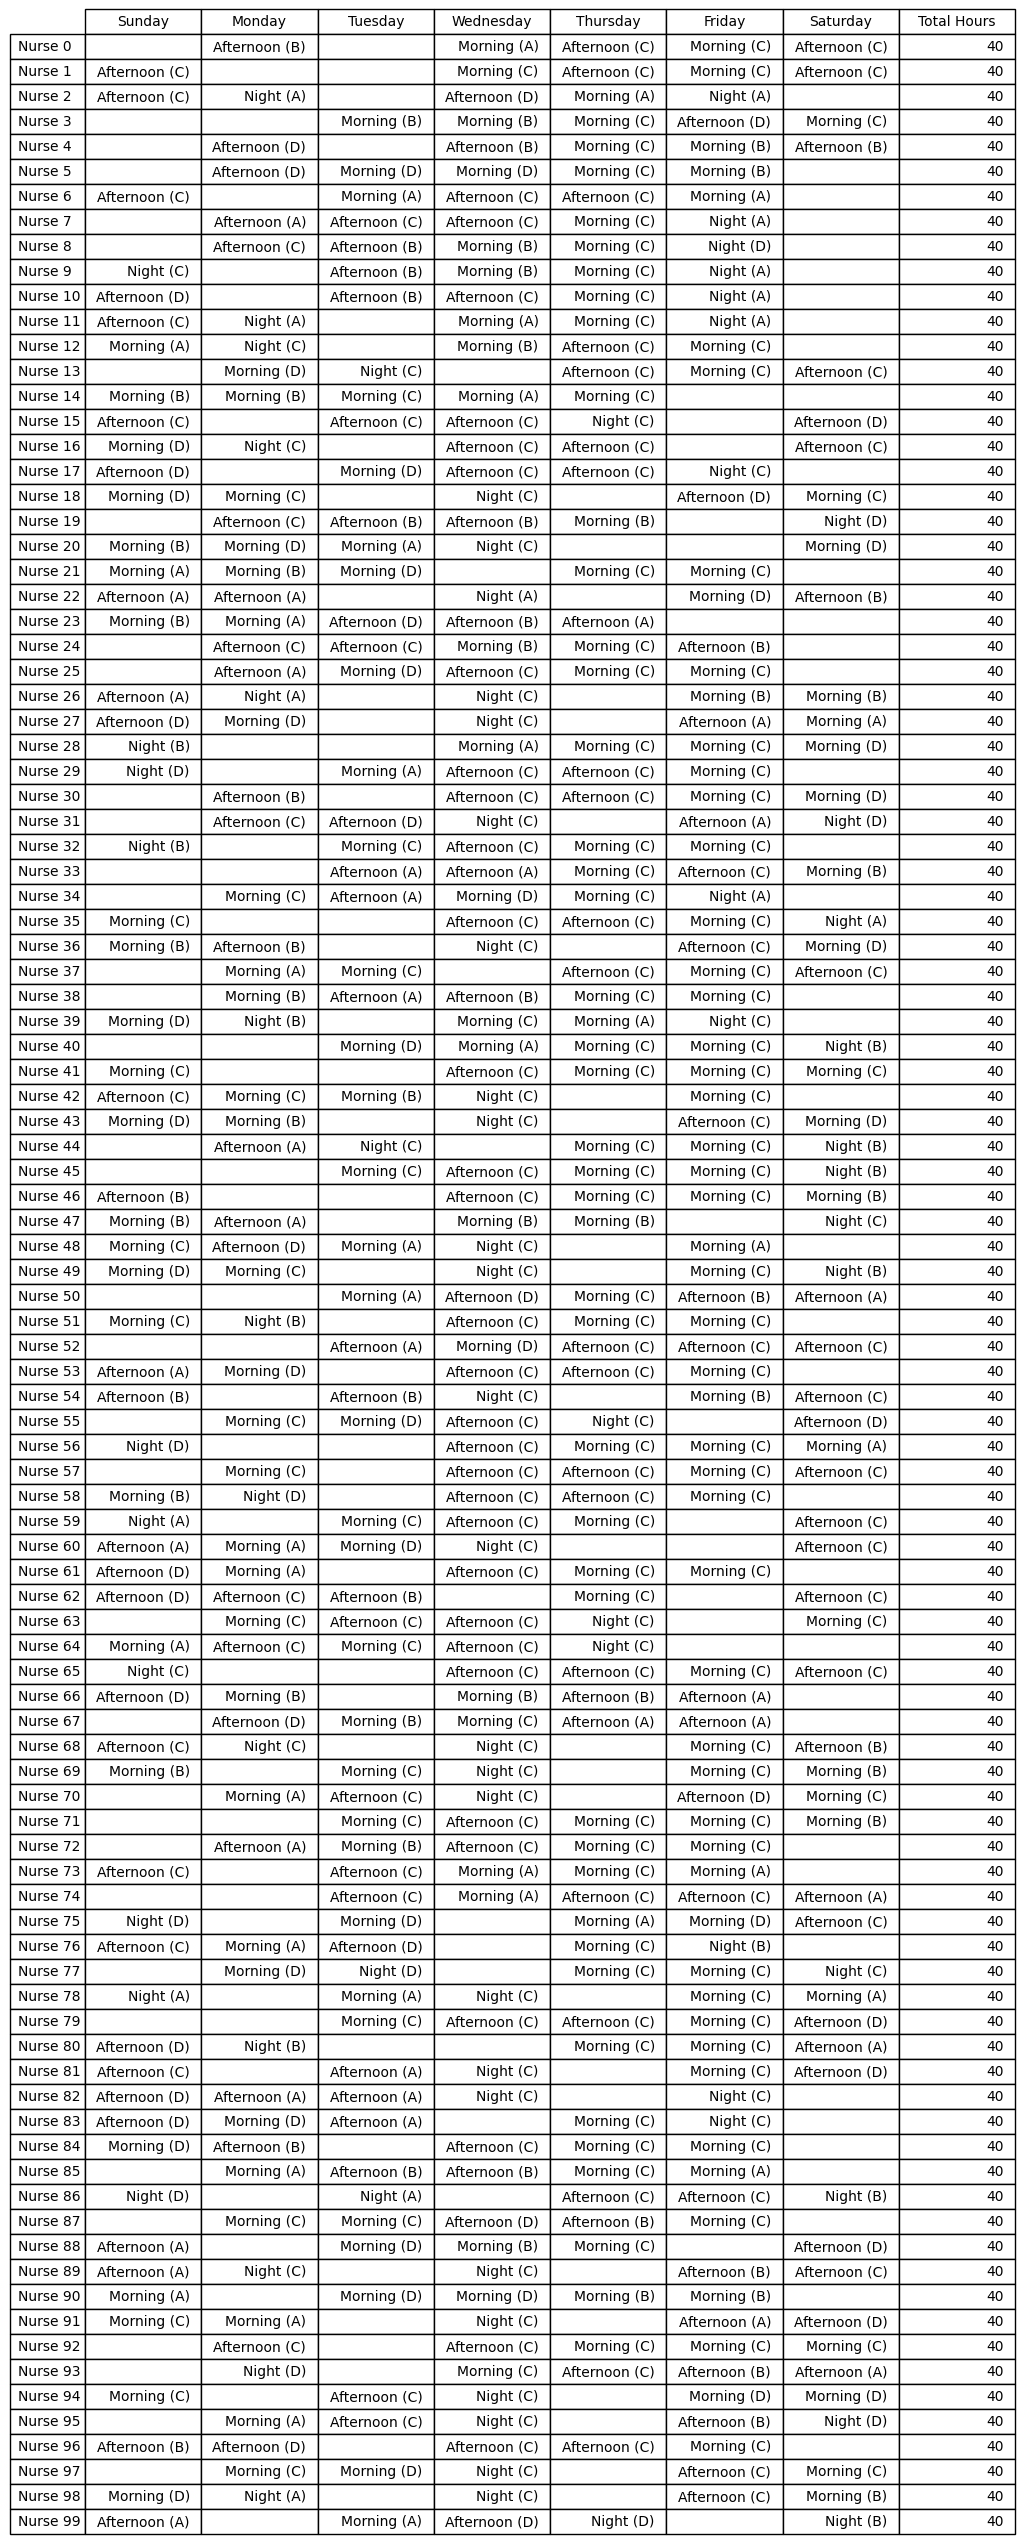

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming these variables are available from your model:
# - nurses: list or range of nurse indices
# - days: list of day indices (0=Sunday, 1=Monday, …, 6=Saturday)
# - day_names: dictionary mapping day index to day name (e.g., {0:'Sunday', ...})
# - skills: list of skills (e.g., ['A','B','C','D'])
# - shifts: list of shifts (e.g., ['Morning','Afternoon','Night'])
# - x: decision variable dictionary from the solved docplex model, where each x[i,j,k,l].solution_value is available.

# Create dictionaries to store the schedule and total hours for each nurse.
schedule_dict = {}
total_hours_dict = {}

for i in nurses:
    nurse_name = f"Nurse {i}"
    schedule_dict[nurse_name] = {}
    total_hours = 0
    for k in days:
        assignment = ""
        for j in skills:
            for l in shifts:
                # Check if the assignment variable is set (considering numerical tolerance).
                if x[i, j, k, l].solution_value > 0.5:
                    # Record the shift and skill (e.g., "Morning (A)")
                    assignment = f"{l} ({j})"
                    total_hours += 8  # each shift represents 8 working hours
        # Save the assignment for the day, or leave blank if no shift was assigned.
        schedule_dict[nurse_name][day_names[k]] = assignment
    total_hours_dict[nurse_name] = total_hours

# Build the schedule DataFrame and add a column for total hours worked.
df_schedule = pd.DataFrame.from_dict(schedule_dict, orient="index")
df_schedule["Total Hours"] = pd.Series(total_hours_dict)

# Ensure the columns are ordered by the days of the week followed by the total hours.
ordered_days = [
    "Sunday",
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
]
df_schedule = df_schedule[ordered_days + ["Total Hours"]]

# For clarity, we will visualize only the first 10 nurses.
df_subset = df_schedule
print(df_subset)

# Create a matplotlib table to visualize the schedule.
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("tight")
ax.axis("off")
table = ax.table(
    cellText=df_subset.values,
    rowLabels=df_subset.index,
    colLabels=df_subset.columns,
    loc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
# plt.title("Nurse Weekly Schedule with Total Hours (First 10 Nurses)")
plt.show()


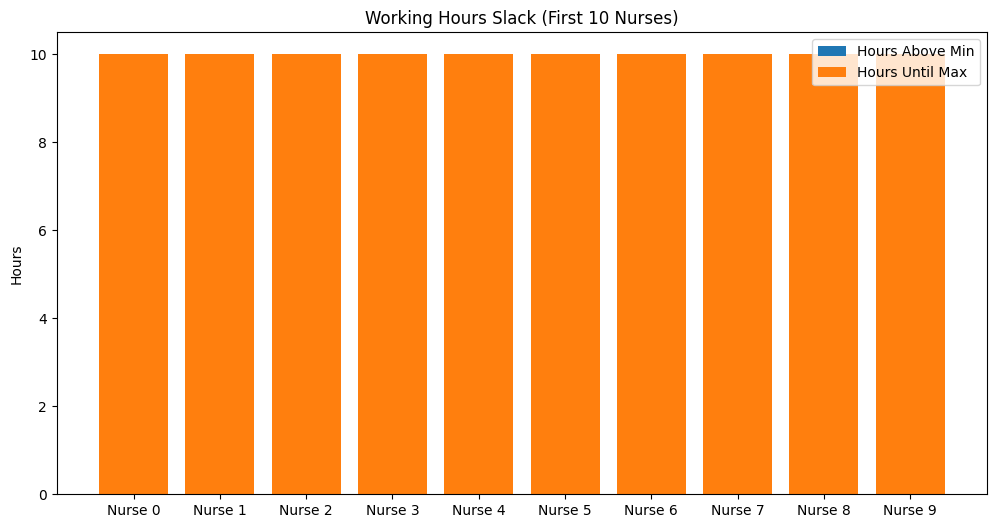

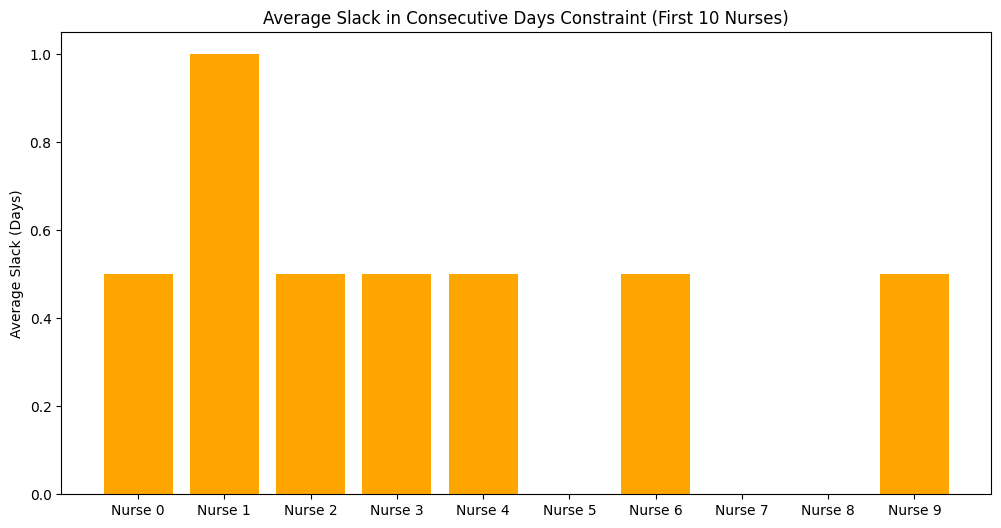

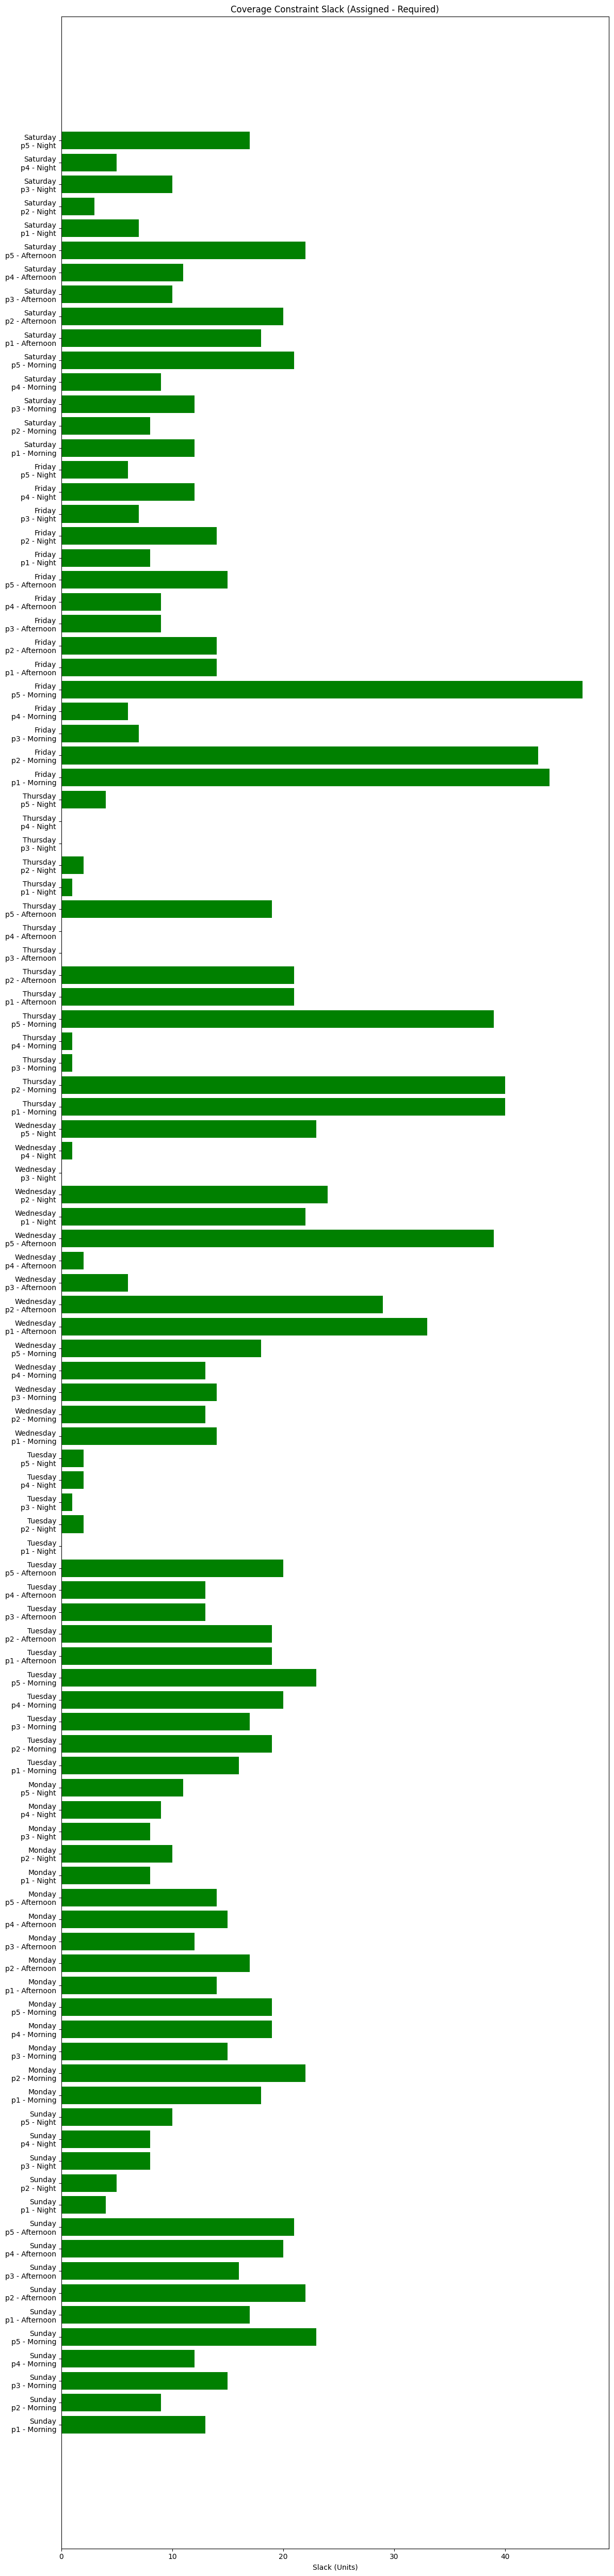

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# For coverage chart: build a reverse mapping from day name to day index.
day_to_index = {v: k for k, v in day_names.items()}

# -------------------------------------------------------------------------
# 1. Working Hours Slack Visualization (for the first 10 nurses)
# -------------------------------------------------------------------------
nurse_labels = []
slack_above_min = []  # Hours above the minimum (total_hours - min_hours)
slack_until_max = []  # Hours remaining until reaching the max (max_hours - total_hours)

for i in range(10):  # showing first 10 nurses for clarity
    nurse_label = f"Nurse {i}"
    total_hours = sum(
        8 * x[i, j, k, l].solution_value for j in skills for k in days for l in shifts
    )
    slack_min = total_hours - min_hours  # extra hours beyond the minimum
    slack_max = max_hours - total_hours  # remaining hours until maximum is reached

    nurse_labels.append(nurse_label)
    slack_above_min.append(slack_min)
    slack_until_max.append(slack_max)

# ----------------------------------------------------------------
# Plot 1: Working Hours Slack (Separate Figure)
# ----------------------------------------------------------------
fig1, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(nurse_labels, slack_above_min, label="Hours Above Min")
ax1.bar(nurse_labels, slack_until_max, bottom=slack_above_min, label="Hours Until Max")
ax1.set_title("Working Hours Slack (First 10 Nurses)")
ax1.set_ylabel("Hours")
ax1.legend()
plt.show()

# -------------------------------------------------------------------------
# 2. Consecutive Days Constraint Slack Visualization (first 10 nurses)
# -------------------------------------------------------------------------
# For each nurse, in every window of 6 consecutive days, the maximum allowed working days is 5.
# We compute the slack as: slack = 5 - (actual working days in window).
consec_slack_avg = []

for i in range(10):
    window_slacks = []
    # For a week of 7 days, there are 7-6+1 = 2 windows of 6 days (0-5 and 1-6).
    for start in range(len(days) - 5):
        working_days = sum(
            x[i, j, k, l].solution_value
            for k in range(start, start + 6)
            for j in skills
            for l in shifts
        )
        window_slack = 5 - working_days
        window_slacks.append(window_slack)
    avg_slack = np.mean(window_slacks)
    consec_slack_avg.append(avg_slack)

# ----------------------------------------------------------------
# Plot 2: Consecutive Days Constraint Slack (Separate Figure)
# ----------------------------------------------------------------
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.bar(nurse_labels, consec_slack_avg, color="orange")
ax2.set_title("Average Slack in Consecutive Days Constraint (First 10 Nurses)")
ax2.set_ylabel("Average Slack (Days)")
plt.show()

# -------------------------------------------------------------------------
# 3. Coverage Constraint Slack Visualization
# -------------------------------------------------------------------------
# For each day, shift, and procedure, compute:
#    slack = (Total weighted assignment) - (Required number)
# Here we loop over each day (using day_names), then for each shift and procedure.
coverage_keys = []
coverage_slacks = []

for day in day_names.values():
    # get the corresponding day index
    k = day_to_index[day]
    for l in shifts:
        for proc, req in coverage_requirements[day].items():
            # Sum over all nurses and skills, weighted by the procedure coefficient.
            total_assigned = sum(
                procedure_skill_coef[proc][j] * x[i, j, k, l].solution_value
                for i in nurses
                for j in skills
            )
            slack = total_assigned - req[l]
            key = f"{day}\n{proc} - {l}"
            coverage_keys.append(key)
            coverage_slacks.append(slack)
# ----------------------------------------------------------------
# Plot 3: Coverage Constraint Slack (Separate Figure with Height 300px)
# ----------------------------------------------------------------
# Matplotlib figures use inches for figsize. If dpi=100, then 300px equals 3 inches.
fig3, ax3 = plt.subplots(figsize=(12, 50))
ax3.barh(coverage_keys, coverage_slacks, color="green")
ax3.set_title("Coverage Constraint Slack (Assigned - Required)")
ax3.set_xlabel("Slack (Units)")
plt.tight_layout()
plt.show()
